# Property Data Preprocessing
This notebook will demonstrate the proprocessing of property data in the following sequence
1. **Data Combining**: combine `Domain data` (retrived from API) and `Old-listing data` (retrieved from webscraping)

2. **Filtering for Residential Property**: By the definition of residential property from Australia Taxation Office (ATO), A residential property includes houses, units, flats and more. It refers to residential property that provides shelter and contains basic living facilities. It doesn't include vacant land. Hence we will only be including the valid ones.

3. **Feature Preprocessing** We will be checking the validity of location(longitude and latitude), number of rooms (bedrooms, bathrooms, carparks), and weekly rent. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os 
import sys
import seaborn as sns
from matplotlib import pyplot as plt
import re

# caution: path[0] is reserved for script path (or '' in REPL)

sys.path.insert(1, '../../scripts/')
import historical7
from historical7 import prepro


## Data Combining
The preprocessing function will loop each raw file and they will be saved as curated data respectively.

In [ ]:
path = "../../data/raw/historical_data/*.csv"
file_lst = []
for fname in glob.glob(path):
    file_lst.append(fname)

for file in file_lst:
    prepro(file, 'historical')

newpath = r'../../data/curated/property_all' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

After looping and preprocess through all historical data, we concatenate them into one dataframe and save them seperately base on year. 

In [ ]:
curated_path = "../../data/curated/historical/*.csv"
file_lst2 = []
for fname in glob.glob(curated_path):
    file_lst2.append(fname)

# combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in file_lst2 ])
# run the following code if you want to generate a whole historical dataset. around 57MB. Thus, will not keep that in git for now.
# export to csv
# combined_csv.to_csv( "../../data/curated/historical/combined_historical.csv", index=False, encoding='utf-8-sig') 

In [ ]:
api_df = pd.read_csv("../../data/curated/API_re_clean.csv")

In [ ]:
COLS = ['address', 'latitude', 'longitude', 'nbed', 'nbath',
       'ncar', 'price', 'type', 'historical_dates', 'postcode', 'year',
       'month', 'suburb', 'weekly_rent']
combined_csv = combined_csv[COLS]
api_df = api_df[COLS]
concat_df = pd.concat([combined_csv, api_df])
concat_df = pd.concat([combined_csv, api_df])
print(f'In total, we have {len(concat_df)} instances, where {len(api_df)} were from domain API and {len(combined_csv)} were from oldlistings.com')

In [ ]:
for file in file_lst2:
    os.remove(file)

In [ ]:
# os.remove("../../data/curated/historical/combined_historical.csv")

## Filtering Residential Properites

In [ ]:
type_df = combined_csv[['type', 'year','weekly_rent','postcode']]\
        .groupby(['type'],as_index = False) \
        .agg(
            {\
                'weekly_rent': 'mean', # count number of instances from sample
                'postcode': 'count'
            }
        ) \
        .rename({'postcode': 'num','weekly_rent': 'averaged_wk_rent' }, axis=1)

type_df

In [ ]:
list(type_df.type)

### residential type classification
We will classify residential types into house, apartment, and other. For the 'other' type, we assume they are residential properties as there is a large amount of them (around 20% of the whole dataset), and we saw that most of them are residential properties when doing web scraping.

In [ ]:
house_lst = [
    '- House',
    'Cottage',
    'Duplex',
    'Duplex Or Semi',
    'Duplex/semi Detach',
    'Duplexsemi',
    'Duplexsemi-detached',
    'House',
    'Houses',
    'Residential House',
    'Semi',
    'Semi Detached',
    'Semi-detached',
    'Semi-detached/duplex',
    'Semi-detatched',
    'Semi-duplex',
    'Townhouse',
    'Villa',
    'Villa, House',
    'Villa, Unit, House',
    ]

In [ ]:
apt_lst = [
 '2 Storey Unit',
 'Apartment',
 'Block Of Units',
 'Block Units',
  'Flat',
 'Flat, Block Of Units',
 'Home Unit',
 'Studio',
 'Unit',
]

In [ ]:
other_residential_lst = [
 'Available',
 'Available Now',
 'Rental',
 'Rental Property',
 'Rental_residential',
 'Residential',
 'Residential Home',
 'Residential House',
 'Residential Lease',
 'Residential Rentals',
 'none']

In [ ]:
all_lst = house_lst + apt_lst + other_residential_lst
all_lst

In [ ]:
concat_df.type

In [ ]:
residential_df = concat_df[concat_df['type'].isin(all_lst)]
print(f'{len(concat_df)-len(residential_df)} instances were dropped as they were not residential rental properties, {len(residential_df)} instances were left.')

In [ ]:
import numpy as np
#df = residential_df
conditions = [
    (residential_df['type'].isin(house_lst)),
    (residential_df['type'].isin(apt_lst)),
    (residential_df['type'].isin(other_residential_lst)),
    ]
values = ['House', 'Apartment', 'Other']
residential_df['residence_type'] = np.select(conditions, values)
residential_df.head()

In [ ]:
YEARS = []
for i in range(2006,2023):
    YEARS.append(i)
YEARS
for year in YEARS:
    df = residential_df[residential_df.year == year]
    df.to_csv(f'../../data/curated/property_all/{year}_historical_clean.csv')

#### further visual checking after only keeping rental residential properties

In [ ]:
import pandas as pd
import glob
import seaborn as sns
import numpy as np

In [ ]:
curated_path = "../../data/curated/property_all/*.csv"
file_lst2 = []
for fname in glob.glob(curated_path):
    file_lst2.append(fname)

# combine all files in the list
residential_df = pd.concat([pd.read_csv(f) for f in file_lst2 ])

In [ ]:
type_df2 = residential_df[['residence_type', 'year','weekly_rent','postcode']]\
        .groupby(['residence_type'],as_index = False) \
        .agg(
            {\
                'weekly_rent': 'mean', # count number of instances from sample
                'postcode': 'count'
            }
        ) \
        .rename({'postcode': 'num','weekly_rent': 'averaged_wk_rent' }, axis=1)

type_df2

In [ ]:
#plt.figure(figsize=(15,15))
ax = sns.barplot(
    data=type_df2, x="num", y="residence_type",
)

## Preprocessing Features
### Locations

In [ ]:
residential_df.longitude.astype(str).str.len().describe()

In [ ]:
residential_df.latitude.astype(str).str.len().describe()

In [ ]:
residential_df[residential_df.longitude.astype(str).str.len() == 18]

In [ ]:
residential_df[residential_df.latitude.astype(str).str.len() == 158]

In [ ]:
old_value = residential_df[residential_df.latitude.astype(str).str.len() == 158].latitude.iloc[0]
old_value1 = residential_df[residential_df.latitude.astype(str).str.len() == 158].latitude.iloc[1]
old_value2 = residential_df[residential_df.latitude.astype(str).str.len() == 158].latitude.iloc[2]
new_value = '-36.8826280'
residential_df['latitude'] = residential_df['latitude'].replace([old_value],new_value)
residential_df['latitude'] = residential_df['latitude'].replace([old_value1],new_value)
residential_df['latitude'] = residential_df['latitude'].replace([old_value2],new_value)


In [ ]:
residential_df.latitude.astype(str).str.len().describe()

In [ ]:
residential_df[residential_df.latitude.astype(str).str.len() == 19]

### Number of Rooms

In [ ]:
ax = sns.boxplot(data=residential_df[['nbed','ncar','nbath']])

In [ ]:
residential_df[residential_df.nbath > 5]

double check:

https://www.realestate.com.au/property/47-barber-st-pyramid-hill-vic-3575

For '47 BARBER STREET, PYRAMID HILL' since the rental price is relatively low, for this property, we google for confirmation. From google, we can tell the number of bathroom for this property is 1.0.

https://www.domain.com.au/rm-6-6-corrigan-st-burwood-vic-3125-8539197

This one suggests that 'RM 6/6 CORRIGAN ST, BURWOOD' is not oulier with large number of rooms and low price.

In [ ]:
residential_df.loc[residential_df['address'] == '47 BARBER STREET, PYRAMID HILL' , 'nbath'] = 1

In [ ]:
residential_df.loc[residential_df['address'] == '47 BARBER STREET, PYRAMID HILL']
# after removing this, we can see that the number of bedrroms are also large hence we assume there's no outliers for nbed and nbath

### Weekly rent
#### 2013 as example

In [ ]:
df_2013 = residential_df[residential_df.year == 2013]

In [ ]:
COLS = ['address','type','weekly_rent','postcode','nbed','nbath','ncar','residence_type']

In [ ]:
df_2013 = df_2013[COLS]
df_2013

In [ ]:
ax = sns.boxplot(data=df_2013[['weekly_rent']])

In [ ]:
df_2013[df_2013['weekly_rent'] > 3000]

The mentioned above instances are all outliers. Hence, we consider removing values outsided of 3 standard devisation.

102/8 Bligh Place, Melbourne, Vic 3000: $890 per week in 2022: https://www.realestate.com.au/property-apartment-vic-melbourne-429072318

15 RICHARD STREET, WILLIAMSTOWN: $1,100pw in 2022: https://www.homely.com.au/homes/15-richard-street-williamstown-vic-3016/5250272

37 Murray Drive: $654 pw in 2022: https://www.propertyvalue.com.au/property/37-murray-drive-point-leo-vic-3916/12541662

2 Drake Street, Mornington VIC 3931: $1,525PER WEEK in 2022: https://www.domain.com.au/property-profile2-drake-street-mornington-vic-3931

55 BELEURA HILL ROAD, MORNINGTON: $1500.00 pw in 2022: https://www.homely.com.au/homes/55-beleura-hill-road-mornington-vic-3931/1269977

535 Great Ocean Road Moggs Creek VIC 3231: $552 pw in 2022: https://www.propertyvalue.com.au/property/535-great-ocean-road-moggs-creek-vic-3231/11874101

30 Shoreham Road Shoreham VIC 3916: $850/w in 2022: https://www.onthehouse.com.au/property/vic/shoreham-3916/30-shoreham-rd-shoreham-vic-3916-8066322

148 BROUGHAM STREET, KEW: $995.00 per week in 2022: https://www.domain.com.au/148-brougham-street-kew-vic-3101-15300836


In [ ]:
import numpy as np
from scipy import stats

In [ ]:
df_2013_rent = df_2013[(np.abs(stats.zscore(df_2013.weekly_rent)) < 3)]
print(f'{len(df_2013) - len(df_2013_rent)} instances were dropped from {len(df_2013)}, {len(df_2013_rent)} remaining')

In [ ]:
ax = sns.boxplot(data=df_2013_rent.weekly_rent)

#### 2014 as example

In [ ]:
df_2014 = residential_df[residential_df.year == 2014]

In [ ]:
ax = sns.boxplot(data=df_2014[['weekly_rent']])

In [ ]:
df_2014_rent = df_2014[(np.abs(stats.zscore(df_2014.weekly_rent)) < 3)]
print(f'{len(df_2014) - len(df_2014_rent)} ({round((len(df_2014) - len(df_2014_rent))/len(df_2014)*100,2)}%) instances were dropped from {len(df_2014)}, {len(df_2014_rent)} remaining')

In [ ]:
ax = sns.boxplot(data=df_2013_rent.weekly_rent)

#### Preprocess rent for all
As approaches for rental outliers detection is quite are quite similar, we apply a function for this.

In [529]:
sys.path.insert(1, '../../scripts/')
import outlier_drop_
from outlier_drop_ import outlier_removal

In [530]:
for year in YEARS:
    df = residential_df[residential_df.year ==year]
    df.to_csv(f'../../data/curated/property_all/{str(year)}_historical_clean.csv')

In [532]:
curated_path = "../../data/curated/property_all/*.csv"
property_all_lst = []
for fname in glob.glob(curated_path):
    property_all_lst.append(fname)


In [533]:
property_all_lst = sorted(property_all_lst)

In [534]:
for path in property_all_lst:
    outlier_removal(path)

2006: 11 (2.1%) instances were dropped from 523, 512 remaining
2007: 75 (1.59%) instances were dropped from 4708, 4633 remaining
2008: 98 (1.78%) instances were dropped from 5494, 5396 remaining
2009: 94 (1.82%) instances were dropped from 5172, 5078 remaining
2010: 99 (1.59%) instances were dropped from 6232, 6133 remaining
2011: 135 (1.53%) instances were dropped from 8815, 8680 remaining
2012: 200 (1.8%) instances were dropped from 11117, 10917 remaining
2013: 270 (2.28%) instances were dropped from 11839, 11569 remaining
2014: 251 (1.96%) instances were dropped from 12789, 12538 remaining
2015: 260 (1.97%) instances were dropped from 13188, 12928 remaining
2016: 340 (2.18%) instances were dropped from 15606, 15266 remaining
2017: 420 (2.37%) instances were dropped from 17751, 17331 remaining
2018: 443 (2.18%) instances were dropped from 20320, 19877 remaining
2019: 549 (2.45%) instances were dropped from 22400, 21851 remaining
2020: 607 (2.69%) instances were dropped from 22594, 21

In [1]:
#import pandas as pd
#import glob

curated_path = "../../data/curated/property_all_with_SA2/*.csv"
file_lst2 = []
for fname in glob.glob(curated_path):
    file_lst2.append(fname)

# combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in file_lst2 ])
#combined_csv.to_csv("total_property.csv")

In [9]:
year_df = combined_csv[['type', 'year','weekly_rent','postcode']]\
        .groupby(['year'],as_index = False) \
        .agg(
            {\
                'weekly_rent': 'mean', # count number of instances from sample
                'postcode': 'count'
            }
        ) \
        .rename({'postcode': 'num','weekly_rent': 'averaged_wk_rent' }, axis=1)

year_df

,year,averaged_wk_rent,num
0,2013,365.443223,11466
1,2014,372.474818,12489
2,2015,379.335550,12782
3,2016,385.154309,15119
4,2017,405.824185,17143
5,2018,424.024689,19604
6,2019,433.963905,21554
7,2020,470.199279,21638
8,2021,482.558225,26595
9,2022,505.979537,73107


In [22]:
print(f'in total {sum(year_df.num)} instances after cleaning ')

in total 231497 instances after cleaning 


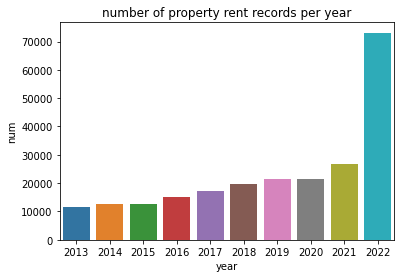

In [18]:
#plt.figure(figsize=(15,15))
plt_title = 'number of property rent records per year'
ax = sns.barplot(
    data=year_df, x="year", y="num",
).set(title = plt_title)
plt.savefig('../../plots/figure/'+ plt_title)

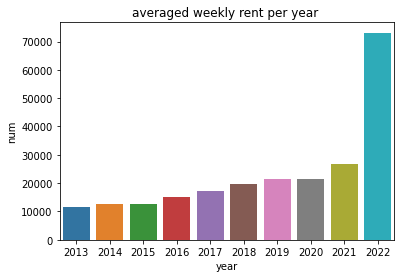

In [19]:
#plt.figure(figsize=(15,15))
plt_title = 'averaged weekly rent per year '
ax = sns.barplot(
    data=year_df, x="year", y="num",
).set(title = plt_title)
plt.savefig('../../plots/figure/'+ plt_title)

In [535]:
import shutil
historical_path = '../../data/curated/historical'
property_all_path = newpath
shutil.rmtree(historical_path)
shutil.rmtree(property_all_path)